# Objective
  PJM Hourly Energy Consumption Data
  PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the
  United States. It is part of the Eastern Interconnection grid operating an electric
  transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky,
  Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee,
  Virginia, West Virginia, and the District of Columbia.

### Import Libraries


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [4]:
pjme = pd.read_excel('PJMW_MW_Hourly (2).xlsx',index_col=[0] ,parse_dates = [0])
pjme.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077
2002-12-31 02:00:00,4939
2002-12-31 03:00:00,4885
2002-12-31 04:00:00,4857
2002-12-31 05:00:00,4930


In [5]:
pjme.tail(5136)

,PJMW_MW
Datetime,
2017-01-02 00:00:00,5021
2018-08-02 01:00:00,5100
2018-08-02 02:00:00,4840
2018-08-02 03:00:00,4745
2018-08-02 04:00:00,4572
...,...
2018-01-01 20:00:00,8401
2018-01-01 21:00:00,8373
2018-01-01 22:00:00,8238


Start Datetime = 2002-12-31 01:00:00

End Datetime = 2018-01-02 00:00:00

For Train-Test Split = Train Date:138071(End Datetime:2017-01-02 00:00:00)  & Test Date:5135(Start Datetime:2018-08-02 01:00:00)


In [6]:
pjme.shape

(143206, 1)

In [7]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   PJMW_MW  143206 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [8]:
pjme.isna().sum()

PJMW_MW    0
dtype: int64

In [9]:
pjme.isnull().sum()

PJMW_MW    0
dtype: int64

In [10]:
pjme.describe().T

,count,mean,std,min,25%,50%,75%,max
PJMW_MW,143206.0,5602.375089,979.142872,487.0,4907.0,5530.0,6252.0,9594.0


<Axes: >

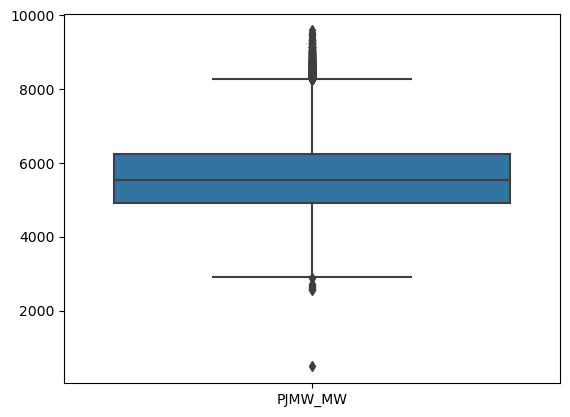

In [11]:
sns.boxplot(pjme)

In [12]:
pjme[pjme['PJMW_MW'] < 500]

,PJMW_MW
Datetime,
2003-05-29,487


In [13]:
pjme['PJMW_MW'] = pjme['PJMW_MW'].replace(['487'], '5602')

In [14]:
Q1=pjme['PJMW_MW'].quantile(0.25)
Q2=pjme['PJMW_MW'].quantile(0.75)
QIR=Q2-Q1
QIR

1345.0

In [15]:
Q1

4907.0

In [16]:
Q2

6252.0

In [17]:
((pjme['PJMW_MW']>(Q2+QIR*1.5))|(pjme['PJMW_MW']<(Q1-QIR*1.5))).sum()

703

In [18]:
mean_value=pjme['PJMW_MW'].mean()

In [19]:
out=(pjme['PJMW_MW']>(Q2+QIR*1.5))|(pjme['PJMW_MW']<(Q1-QIR*1.5))
pjme[out]=np.nan
pjme['PJMW_MW'].fillna(value=mean_value, inplace=True)
pjme

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.000000
2002-12-31 02:00:00,4939.000000
2002-12-31 03:00:00,4885.000000
2002-12-31 04:00:00,4857.000000
2002-12-31 05:00:00,4930.000000
...,...
2018-01-01 20:00:00,5602.375089
2018-01-01 21:00:00,5602.375089
2018-01-01 22:00:00,8238.000000


C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\1807130044.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pjme.PJMW_MW)


<Axes: xlabel='PJMW_MW', ylabel='Density'>

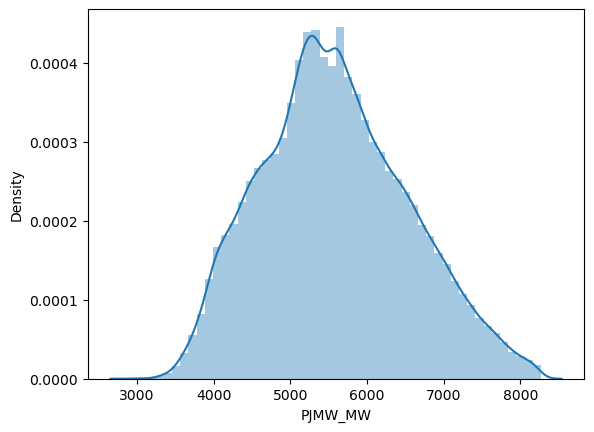

In [20]:
sns.distplot(pjme.PJMW_MW)

There is No skewness in the Dataset

In [21]:
pjme[pjme.duplicated()]

,PJMW_MW
Datetime,
2002-12-30 23:00:00,5885.000000
2002-12-28 09:00:00,6167.000000
2002-12-28 13:00:00,6178.000000
2002-12-28 16:00:00,5962.000000
2002-12-28 22:00:00,6167.000000
...,...
2018-01-01 20:00:00,5602.375089
2018-01-01 21:00:00,5602.375089
2018-01-01 22:00:00,8238.000000


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

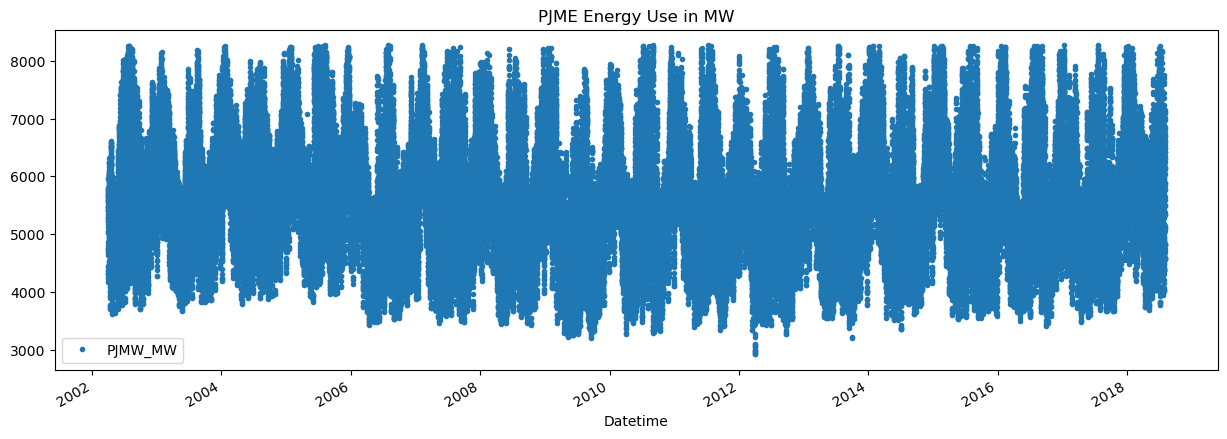

In [22]:
color_pal= sns.color_palette()
pjme.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

## EDA

In [23]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.weekofyear
pjme.drop(['date'], axis = 1, inplace=True)

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\4040693951.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  pjme['weekofyear'] = pjme['date'].dt.weekofyear


In [24]:
pjme.head(50)

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,5077.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,4939.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,4885.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4857.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,4930.0,5,1,4,12,2002,365,31,1
2002-12-31 06:00:00,5126.0,6,1,4,12,2002,365,31,1
2002-12-31 07:00:00,5493.0,7,1,4,12,2002,365,31,1
2002-12-31 08:00:00,5824.0,8,1,4,12,2002,365,31,1
2002-12-31 09:00:00,5962.0,9,1,4,12,2002,365,31,1


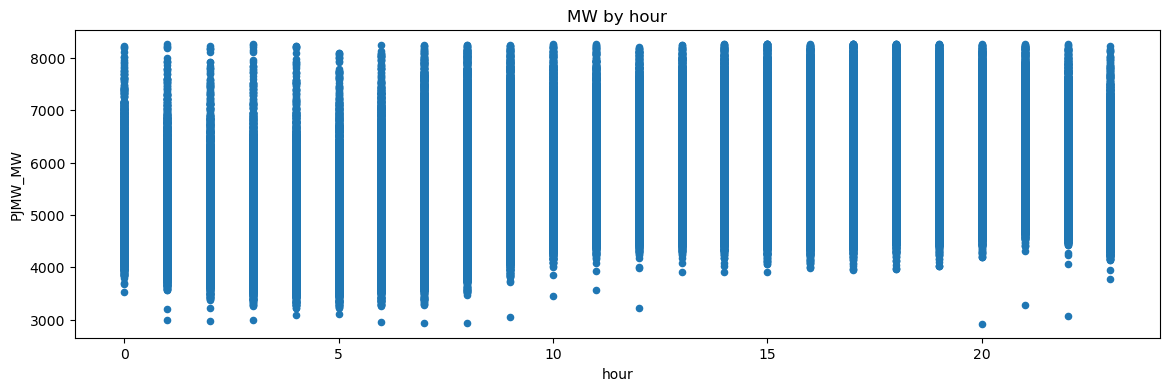

In [25]:
_ = pjme.plot(x='hour', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by hour')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\3469932791.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='hour', y='PJMW_MW', palette='Black',marker='o')


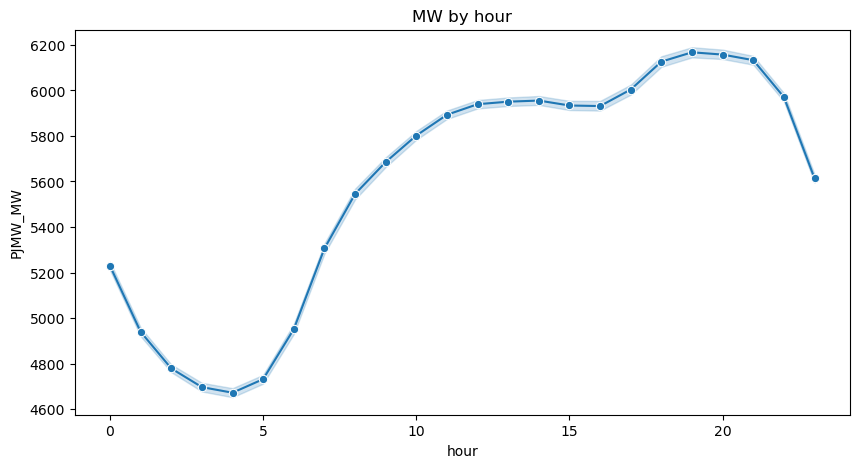

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='hour', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by hour')
plt.show()

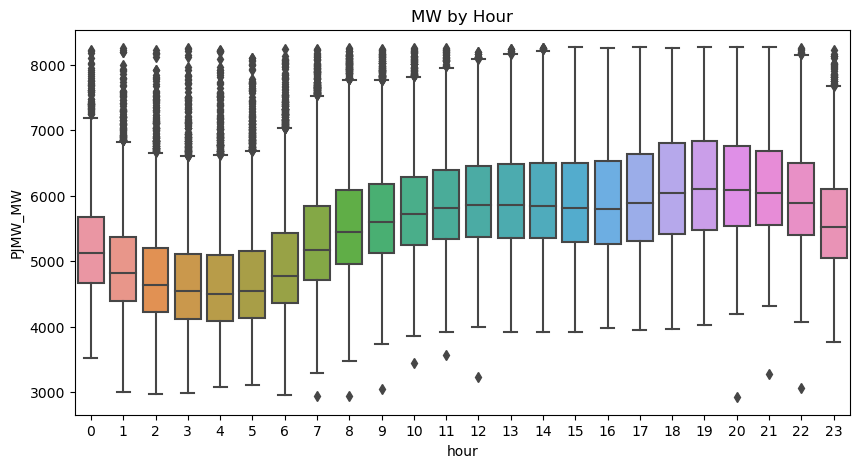

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='hour', y='PJMW_MW')
ax.set_title('MW by Hour')
plt.show()

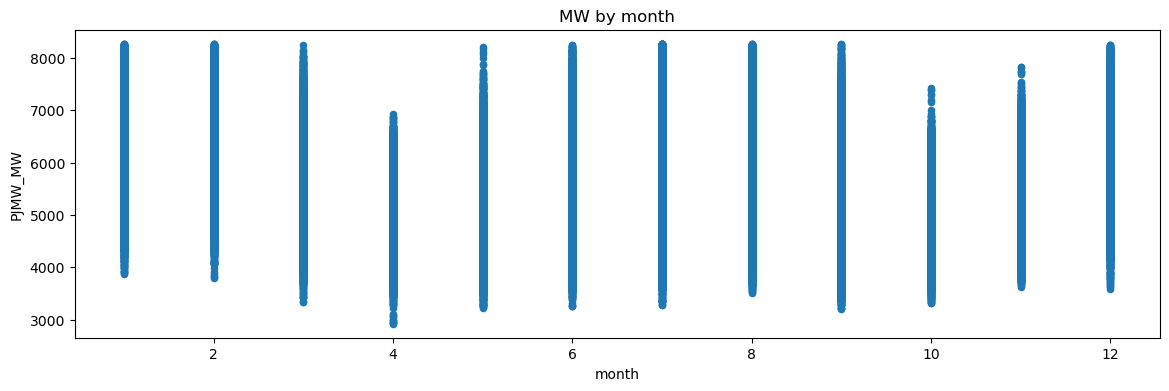

In [28]:
_ = pjme.plot(x='month', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by month')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\2538015243.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='month', y='PJMW_MW', palette='Black',marker='o')


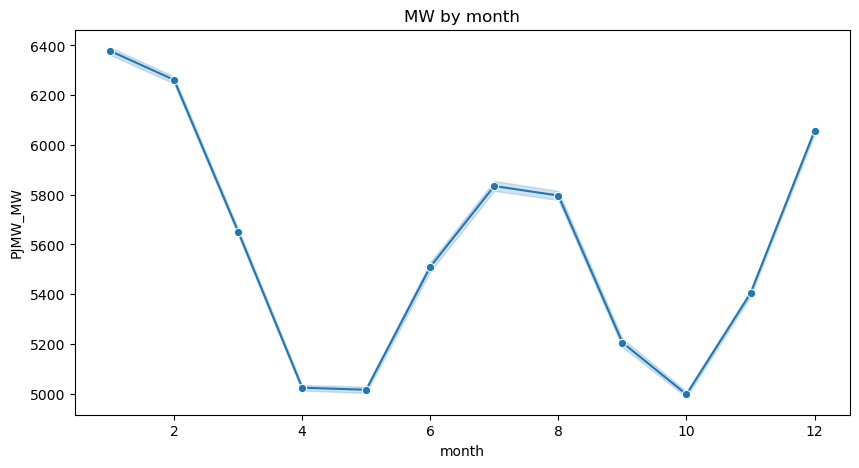

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='month', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by month')
plt.show()

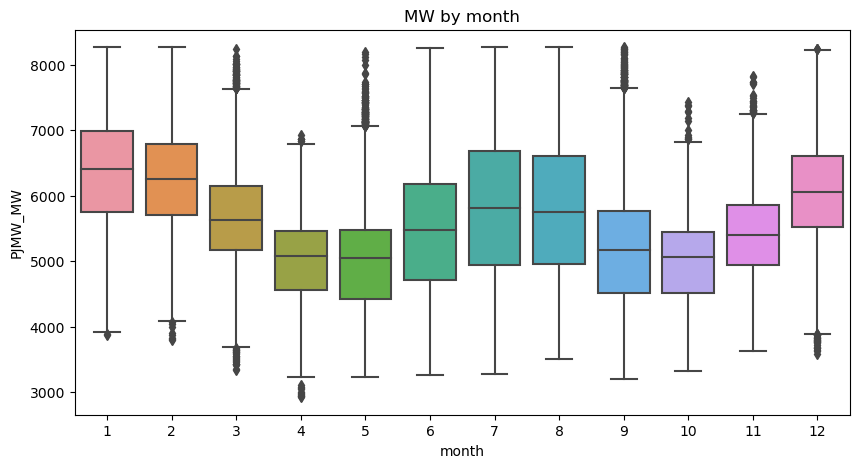

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='month', y='PJMW_MW')
ax.set_title('MW by month')
plt.show()

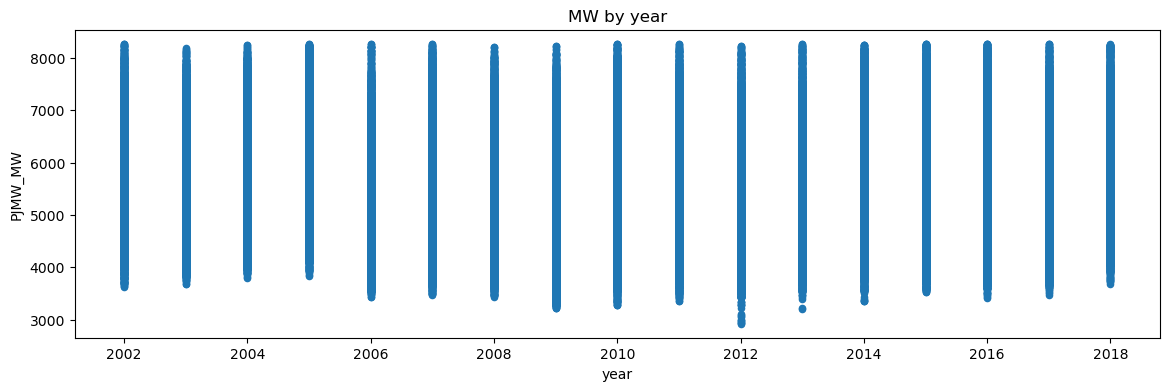

In [31]:
_ = pjme.plot(x='year', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by year')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\1396654432.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='year', y='PJMW_MW', palette='Black',marker='o')


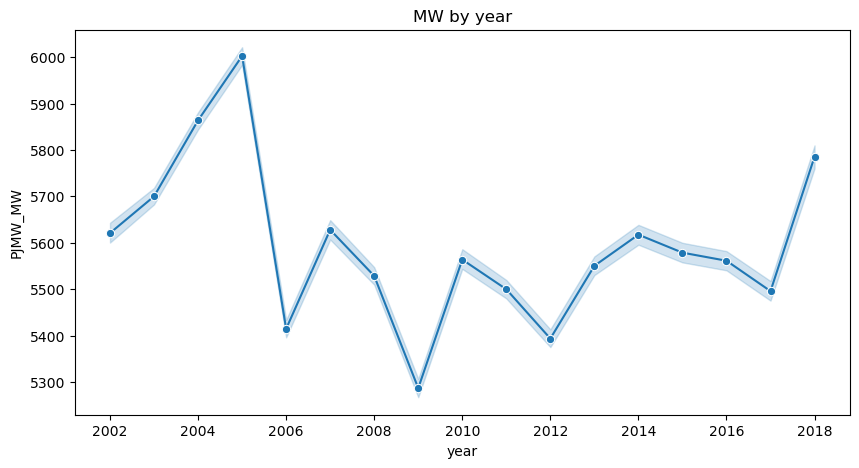

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='year', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by year')
plt.show()

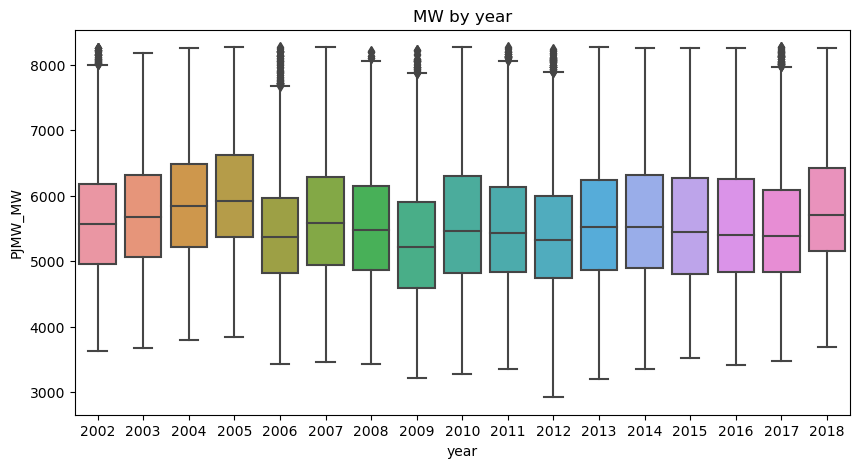

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='year', y='PJMW_MW')
ax.set_title('MW by year')
plt.show()

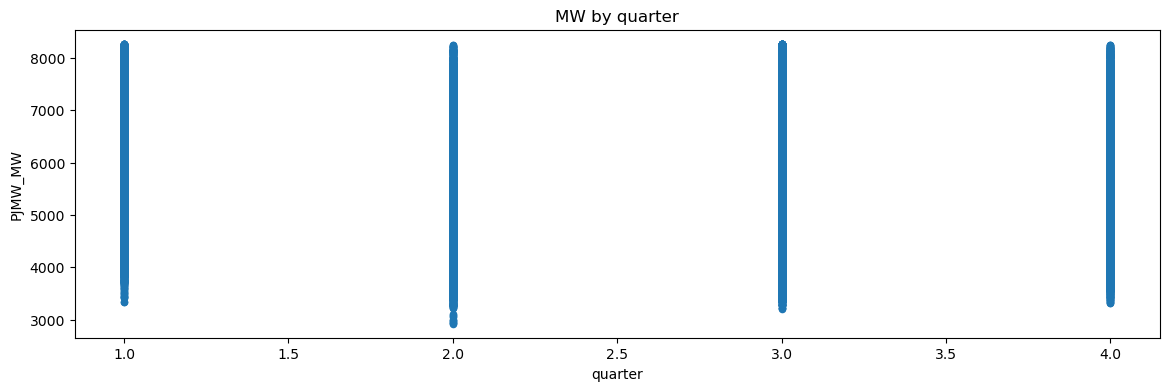

In [34]:
_ = pjme.plot(x='quarter', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by quarter')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\2918576862.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='quarter', y='PJMW_MW', palette='Black',marker='o')


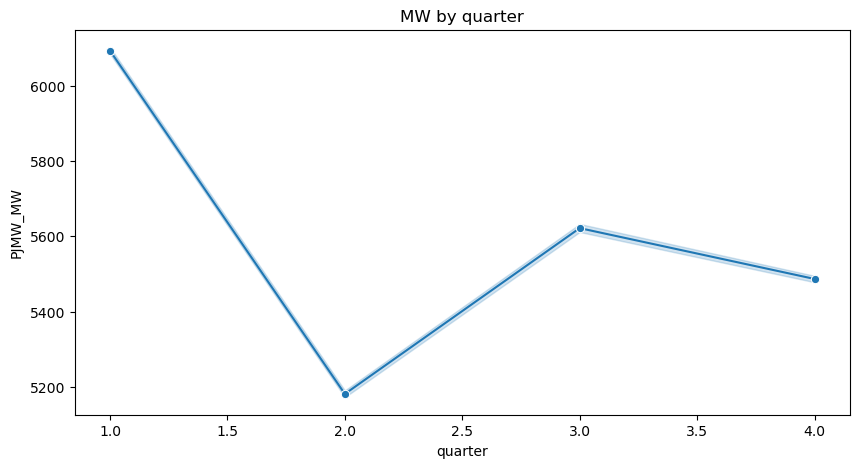

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='quarter', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by quarter')
plt.show()

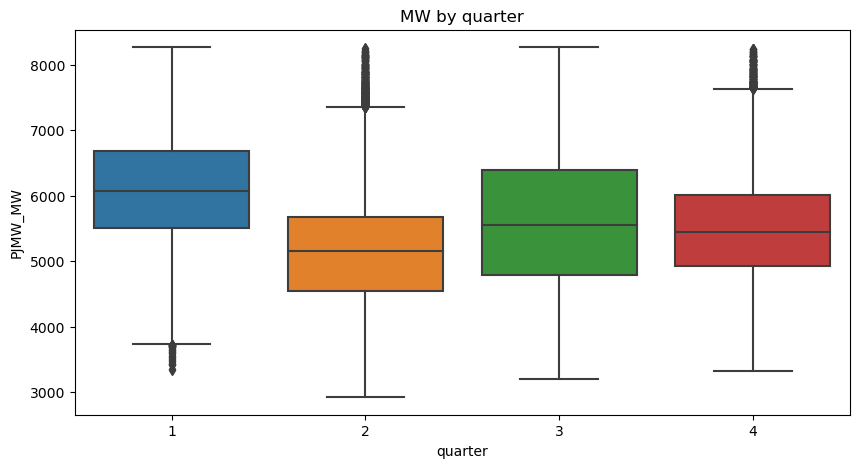

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='quarter', y='PJMW_MW')
ax.set_title('MW by quarter')
plt.show()

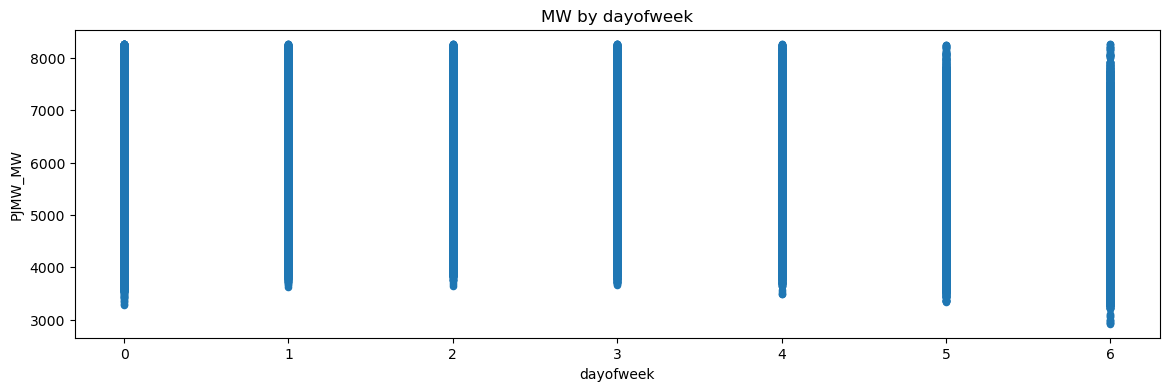

In [37]:
_ = pjme.plot(x='dayofweek', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by dayofweek')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\3430276223.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='dayofweek', y='PJMW_MW', palette='Black',marker='o')


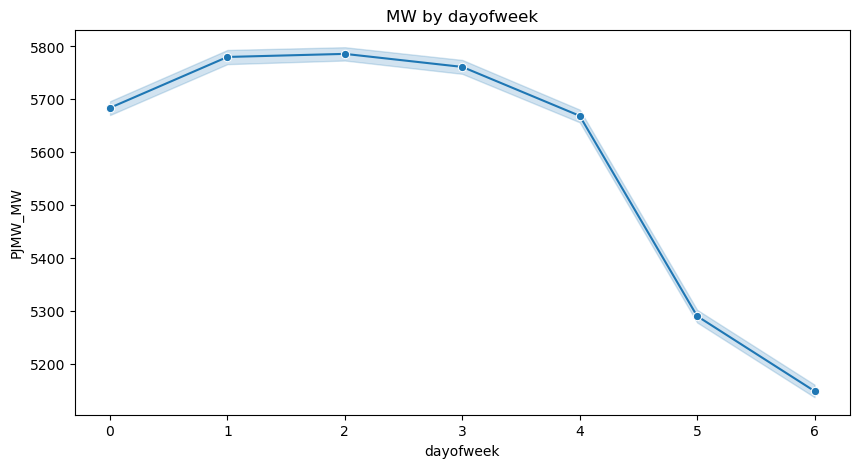

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='dayofweek', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by dayofweek')
plt.show()

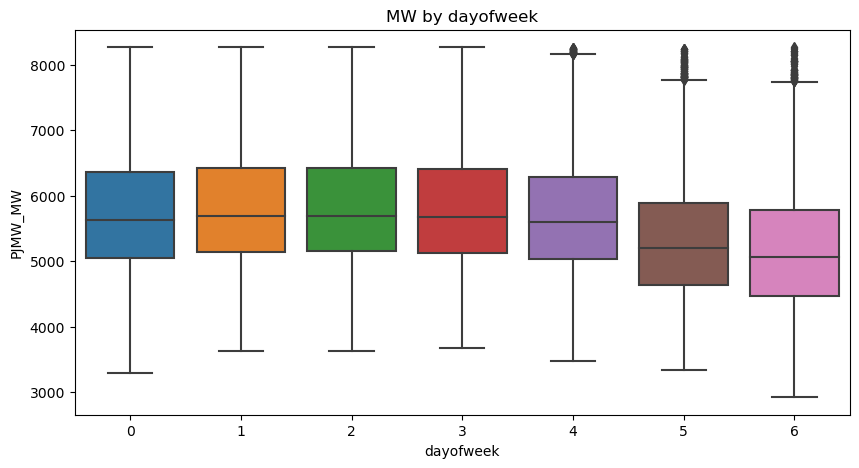

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='dayofweek', y='PJMW_MW')
ax.set_title('MW by dayofweek')
plt.show()

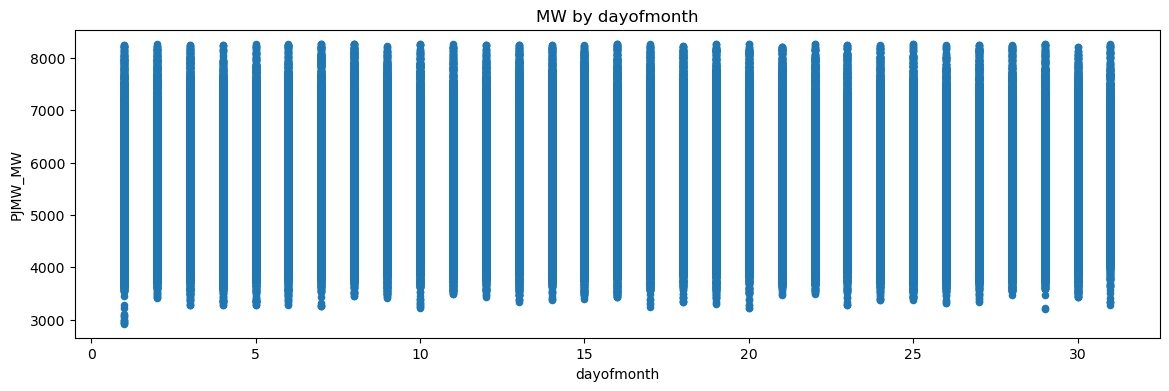

In [40]:
_ = pjme.plot(x='dayofmonth', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by dayofmonth')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\3522763309.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='dayofmonth', y='PJMW_MW', palette='Black',marker='o')


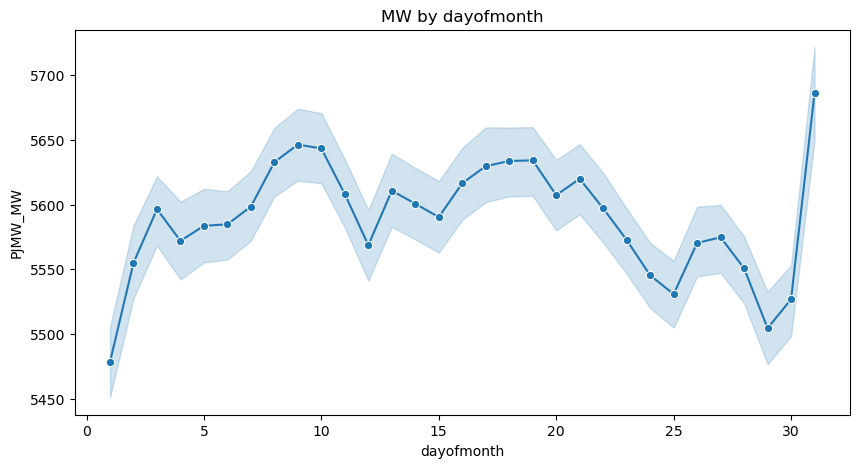

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='dayofmonth', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by dayofmonth')
plt.show()

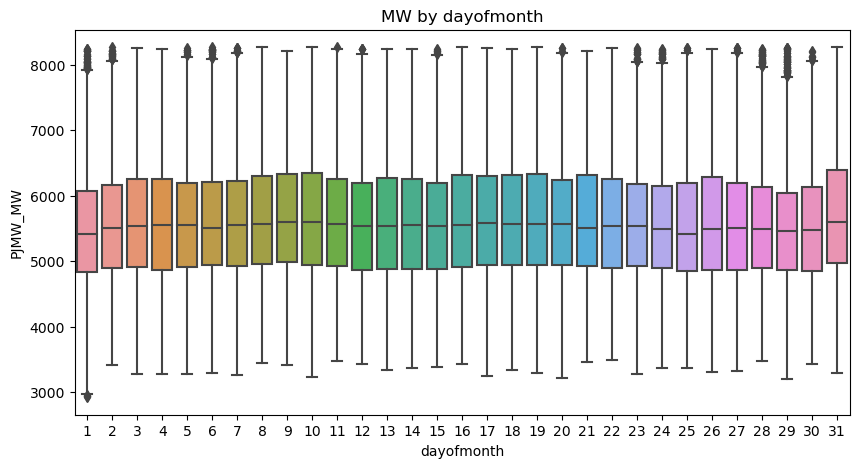

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pjme, x='dayofmonth', y='PJMW_MW')
ax.set_title('MW by dayofmonth')
plt.show()

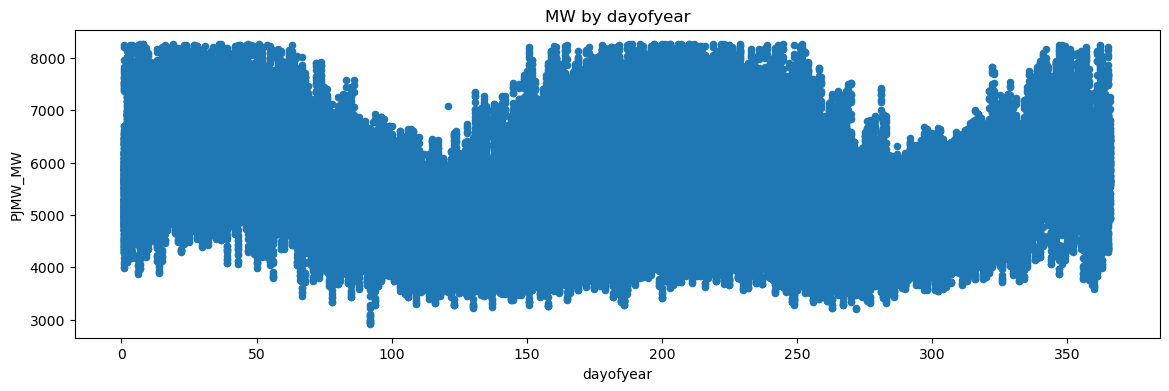

In [43]:
_ = pjme.plot(x='dayofyear', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by dayofyear')

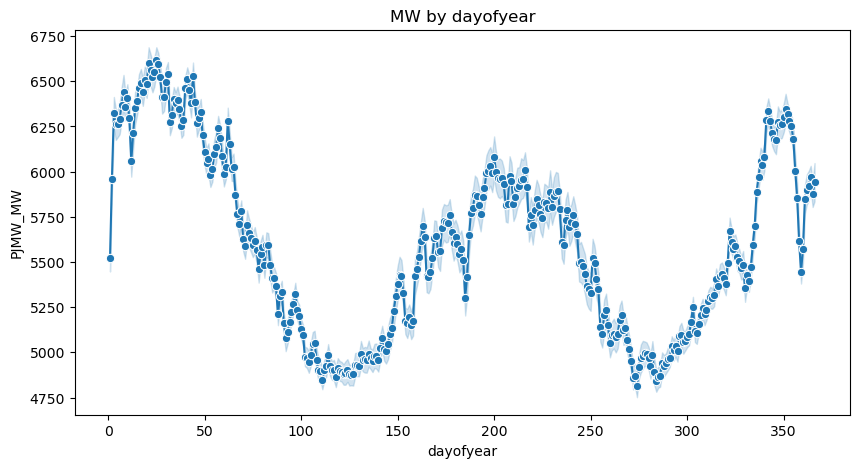

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='dayofyear', y='PJMW_MW',marker='o')
ax.set_title('MW by dayofyear')
plt.show()

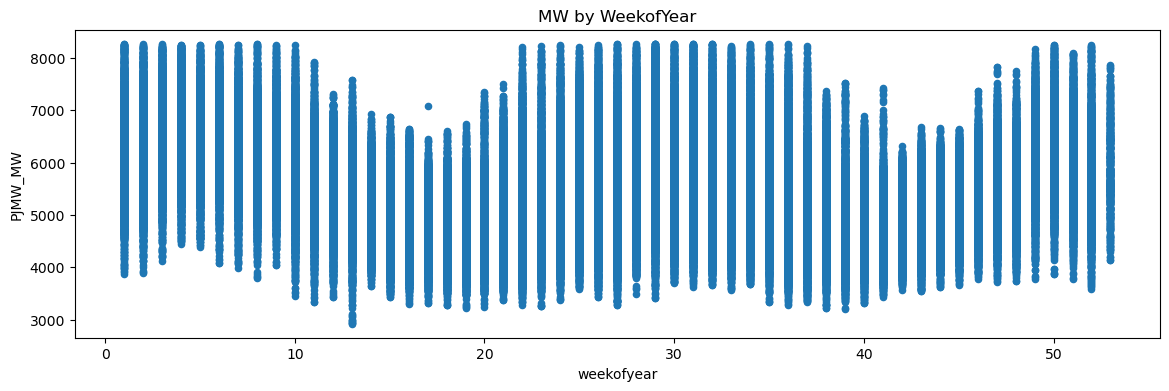

In [45]:
_ = pjme.plot(x='weekofyear', y='PJMW_MW',kind='scatter',figsize=(14,4),title='MW by WeekofYear')

C:\Users\PRASH\AppData\Local\Temp\ipykernel_8004\419718365.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=pjme, x='weekofyear', y='PJMW_MW', palette='Black',marker='o')


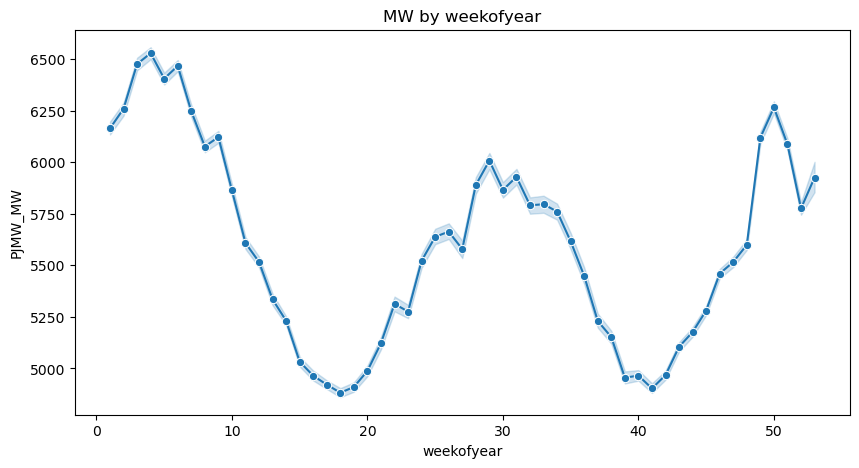

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=pjme, x='weekofyear', y='PJMW_MW', palette='Black',marker='o')
ax.set_title('MW by weekofyear')
plt.show()

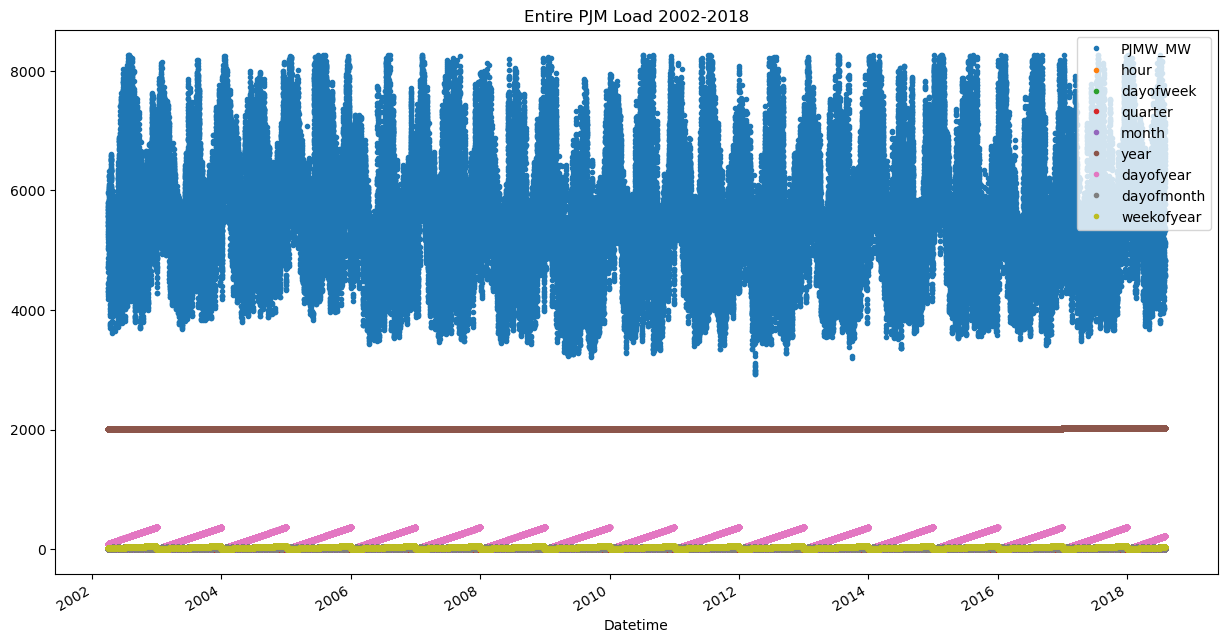

In [47]:
plot = pjme.plot(style='.', figsize=(15, 8), title='Entire PJM Load 2002-2018')

In [48]:
pjme.head(50)

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,5077.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,4939.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,4885.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4857.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,4930.0,5,1,4,12,2002,365,31,1
2002-12-31 06:00:00,5126.0,6,1,4,12,2002,365,31,1
2002-12-31 07:00:00,5493.0,7,1,4,12,2002,365,31,1
2002-12-31 08:00:00,5824.0,8,1,4,12,2002,365,31,1
2002-12-31 09:00:00,5962.0,9,1,4,12,2002,365,31,1


In [49]:
pjme.corr()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
PJMW_MW,1.000000,0.451050,-0.201910,-0.154345,-0.144927,-0.055647,-0.143340,-0.004471,-0.144182
hour,0.451050,1.000000,0.000316,-0.000050,-0.000045,-0.000141,-0.000053,-0.000091,-0.000059
dayofweek,-0.201910,0.000316,1.000000,0.000378,0.000036,0.000392,0.000019,-0.000238,-0.000075
quarter,-0.154345,-0.000050,0.000378,1.000000,0.970842,-0.077200,0.967610,0.011846,0.945401
month,-0.144927,-0.000045,0.000036,0.970842,1.000000,-0.077594,0.996439,0.010118,0.970049
year,-0.055647,-0.000141,0.000392,-0.077200,-0.077594,1.000000,-0.077337,-0.001908,-0.076219
dayofyear,-0.143340,-0.000053,0.000019,0.967610,0.996439,-0.077337,1.000000,0.094099,0.971511
dayofmonth,-0.004471,-0.000091,-0.000238,0.011846,0.010118,-0.001908,0.094099,1.000000,0.067337
weekofyear,-0.144182,-0.000059,-0.000075,0.945401,0.970049,-0.076219,0.971511,0.067337,1.000000


<Axes: ylabel='Datetime'>

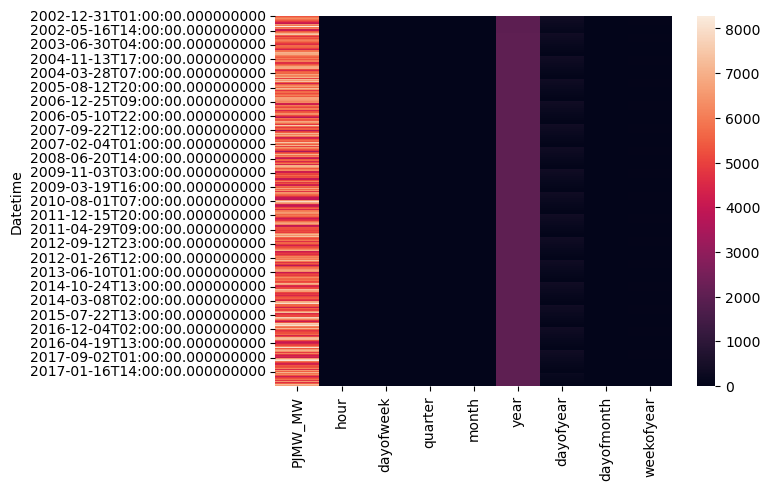

In [50]:
sns.heatmap(pjme)

## Definition of additive time series:
### Value = Base Level + Trend + Seasonality + Error

## Definition of multiplicative time Series:
### Value = Base Level x Trend x Seasonality x Error

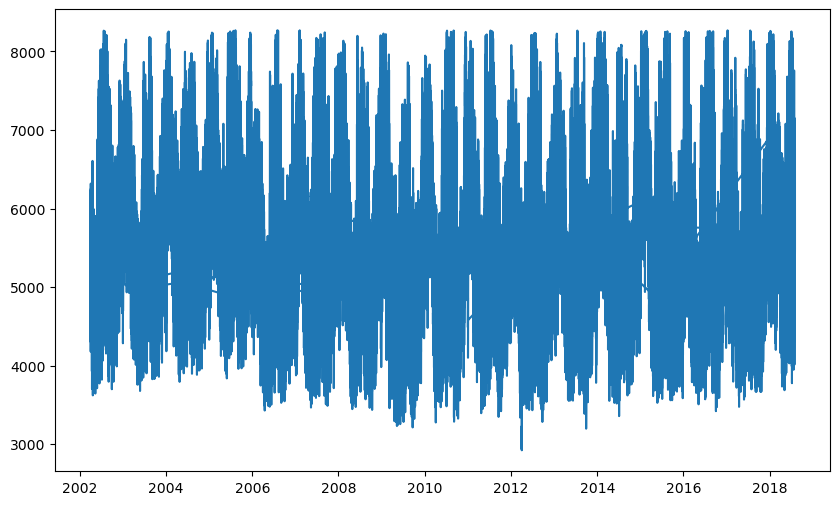

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10,6)})
plt.plot(pjme['PJMW_MW'])

In [52]:
# Multiplicative Decomposition 
mul_result = seasonal_decompose(pjme['PJMW_MW'], model='multiplicative',period=1)

# Additive Decomposition
add_result = seasonal_decompose(pjme['PJMW_MW'], model='additive',period=1)

Text(0.5, 0.98, '\nMultiplicative Decompose')

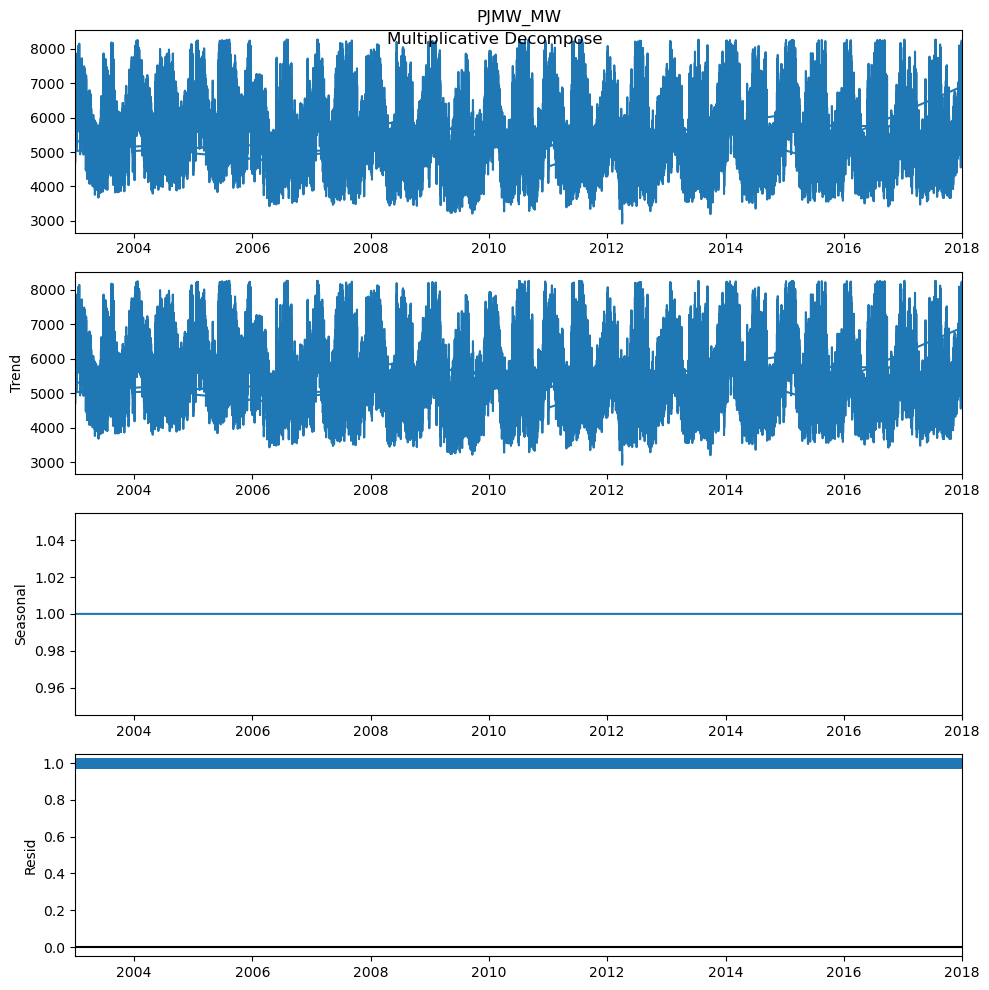

In [53]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

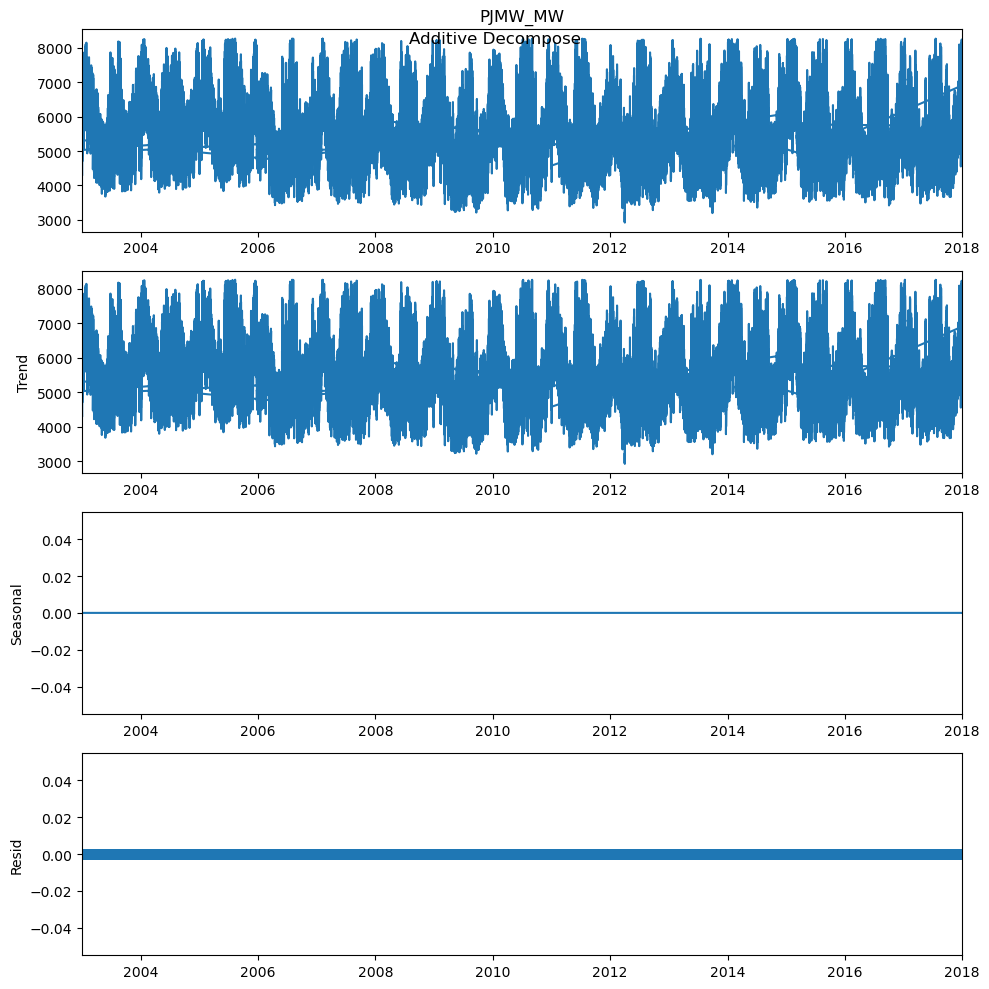

In [54]:
add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)
plt.show()

In [55]:
#Additive
new_df_add = pd.concat([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed], axis=1)
new_df_add.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_add.head(5)

,seasoanilty,trend,residual,actual_values
Datetime,,,,
2002-12-31 01:00:00,0.0,5077.0,0.0,5077.0
2002-12-31 02:00:00,0.0,4939.0,0.0,4939.0
2002-12-31 03:00:00,0.0,4885.0,0.0,4885.0
2002-12-31 04:00:00,0.0,4857.0,0.0,4857.0
2002-12-31 05:00:00,0.0,4930.0,0.0,4930.0


In [56]:
#Multiplicative
new_df_mult = pd.concat([mul_result.seasonal, mul_result.trend, mul_result.resid, mul_result.observed], axis=1)
new_df_mult.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_mult.head(5)

,seasoanilty,trend,residual,actual_values
Datetime,,,,
2002-12-31 01:00:00,1.0,5077.0,1.0,5077.0
2002-12-31 02:00:00,1.0,4939.0,1.0,4939.0
2002-12-31 03:00:00,1.0,4885.0,1.0,4885.0
2002-12-31 04:00:00,1.0,4857.0,1.0,4857.0
2002-12-31 05:00:00,1.0,4930.0,1.0,4930.0


## ADFULLER TEST FOR STATIONARITY

## Definition of stationarity - constant mean and variance

In [58]:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(pjme.PJMW_MW.values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -19.380467103476125
p-value: 0.0
Critial Values:
   1%, -3.4303956883364264
Critial Values:
   5%, -2.8615601935959596
Critial Values:
   10%, -2.5667807483328238


p-value < 5% reject null hypothesis 

Result>>>>Data is Stationary

In [59]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [60]:
df=pd.read_excel('PJMW_MW_Hourly (2).xlsx')
df=df.sort_values(by='Datetime',ascending=True).reset_index(drop=True)
df=df.set_index('Datetime')
df.index= pd.to_datetime(df.index)
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374
2002-04-01 02:00:00,4306
2002-04-01 03:00:00,4322
2002-04-01 04:00:00,4359
2002-04-01 05:00:00,4436
...,...
2018-08-02 20:00:00,6545
2018-08-02 21:00:00,6496
2018-08-02 22:00:00,6325


In [61]:
df[df['PJMW_MW'] < 500]
mean_value=df['PJMW_MW'].mean()
df['PJMW_MW'].fillna(value=mean_value, inplace=True)
out=(df['PJMW_MW']>(Q2+QIR*1.5))|(df['PJMW_MW']<(Q1-QIR*1.5))
df[out]=np.nan
df['PJMW_MW'].fillna(value=mean_value, inplace=True)

In [62]:
# Extract the last datetime value from the dataframe
# Generate a new dataframe with datetime values for the next 30 days
# Create a new dataframe with datetime and PJMW_MW columns for the next 30 days
# Concatenate the previous dataframe and the new dataframe for the next 30 days
# Fill Nan value with mean
last_datetime = df.index[-1]
next_30_days = pd.date_range(last_datetime, periods=24*30, freq='H')
next_30_days_df = pd.DataFrame({'PJMW_MW': np.nan}, index=next_30_days)
df = pd.concat([df, next_30_days_df], axis=0)
df['PJMW_MW'].fillna(mean_value, inplace=True)
df

,PJMW_MW
2002-04-01 01:00:00,4374.000000
2002-04-01 02:00:00,4306.000000
2002-04-01 03:00:00,4322.000000
2002-04-01 04:00:00,4359.000000
2002-04-01 05:00:00,4436.000000
...,...
2018-09-01 19:00:00,5602.375089
2018-09-01 20:00:00,5602.375089
2018-09-01 21:00:00,5602.375089
2018-09-01 22:00:00,5602.375089


# Train/Test Split

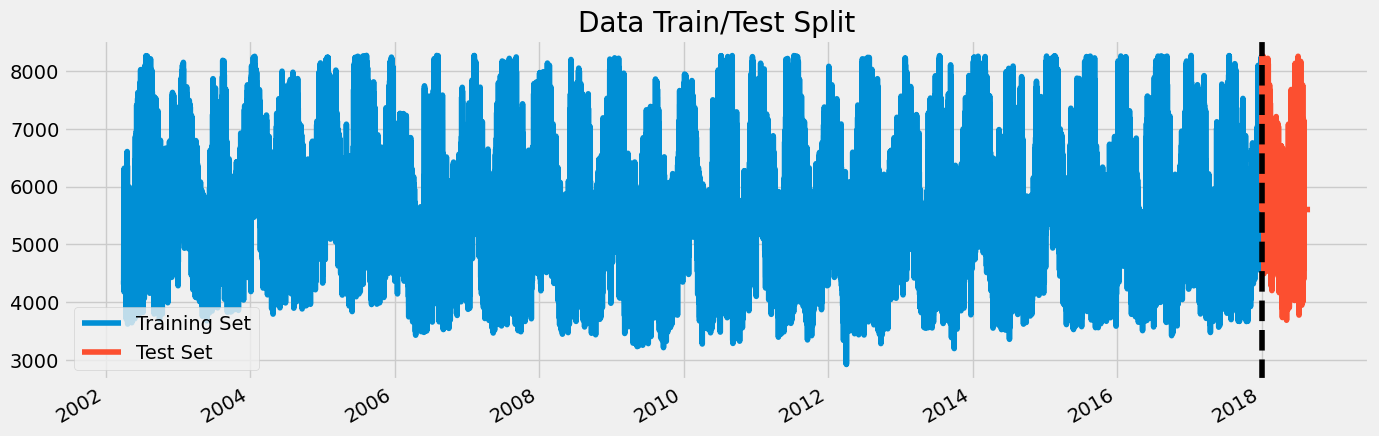

In [63]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.Timestamp('01-01-2018'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

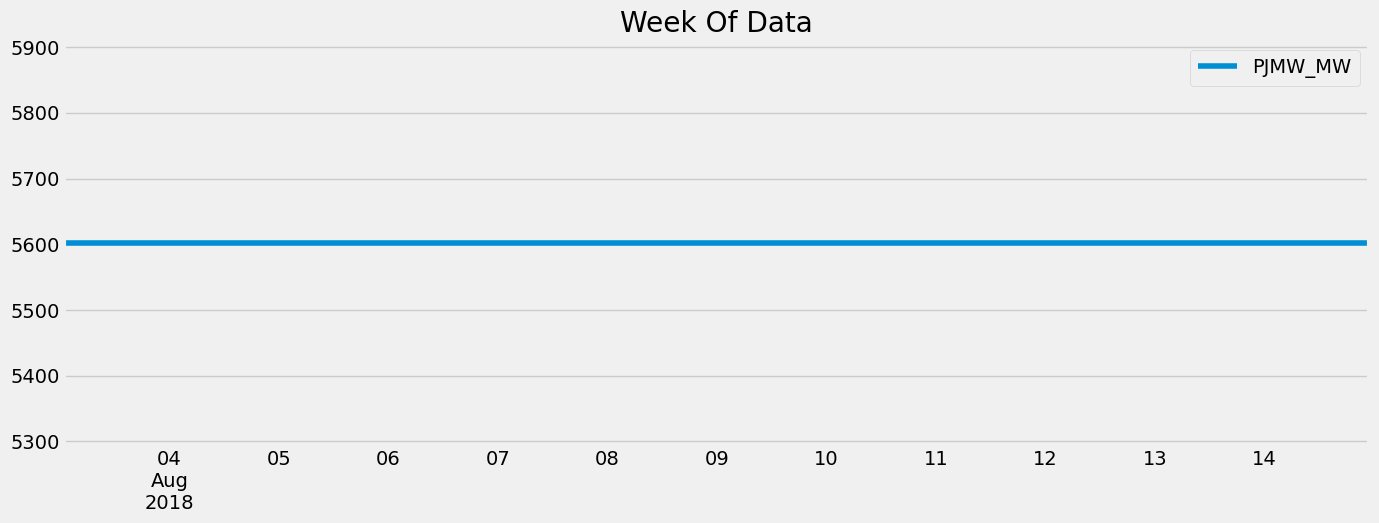

In [67]:
df.loc[(df.index > '08-03-2018') & (df.index < '08-15-2018')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

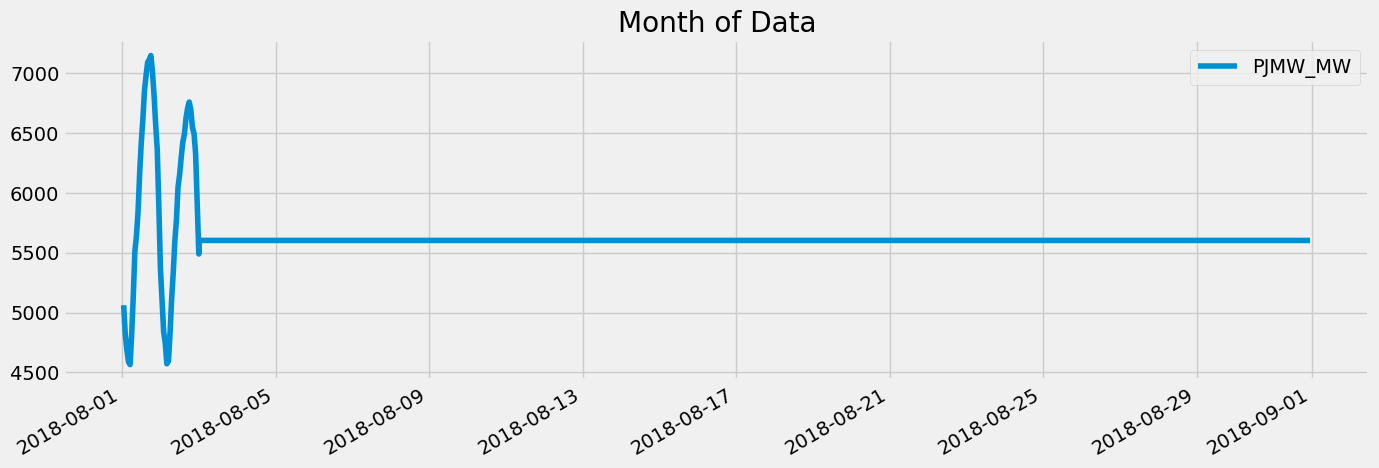

In [68]:
df.loc[(df.index > '08-01-2018') & (df.index < '09-01-2018')] \
    .plot(figsize=(15, 5), title='Month of Data')
plt.show()

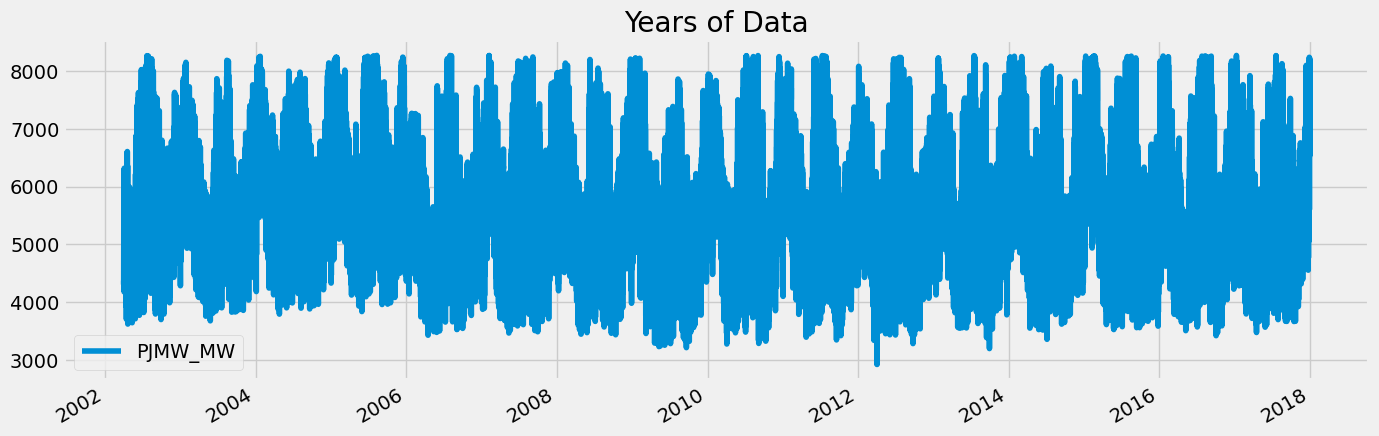

In [69]:
df.loc[(df.index > '01-01-2002') & (df.index < '01-01-2018')] \
    .plot(figsize=(15, 5), title='Years of Data')
plt.show()

In [70]:
df

,PJMW_MW
2002-04-01 01:00:00,4374.000000
2002-04-01 02:00:00,4306.000000
2002-04-01 03:00:00,4322.000000
2002-04-01 04:00:00,4359.000000
2002-04-01 05:00:00,4436.000000
...,...
2018-09-01 19:00:00,5602.375089
2018-09-01 20:00:00,5602.375089
2018-09-01 21:00:00,5602.375089
2018-09-01 22:00:00,5602.375089


In [71]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [72]:
df

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2002-04-01 01:00:00,4374.000000,1,0,2,4,2002,91,1,14
2002-04-01 02:00:00,4306.000000,2,0,2,4,2002,91,1,14
2002-04-01 03:00:00,4322.000000,3,0,2,4,2002,91,1,14
2002-04-01 04:00:00,4359.000000,4,0,2,4,2002,91,1,14
2002-04-01 05:00:00,4436.000000,5,0,2,4,2002,91,1,14
...,...,...,...,...,...,...,...,...,...
2018-09-01 19:00:00,5602.375089,19,5,3,9,2018,244,1,35
2018-09-01 20:00:00,5602.375089,20,5,3,9,2018,244,1,35
2018-09-01 21:00:00,5602.375089,21,5,3,9,2018,244,1,35
2018-09-01 22:00:00,5602.375089,22,5,3,9,2018,244,1,35


## Create Model

In [76]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJMW_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       min_child_weight= 4,
                       nthread= 4,
                       silent= 1,
                       subsample= 0.7,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[09:45:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:5606.17725	validation_1-rmse:5772.12350
[100]	validation_0-rmse:2146.96263	validation_1-rmse:2283.01548
[200]	validation_0-rmse:974.80178	validation_1-rmse:1125.13862
[300]	validation_0-rmse:647.80983	validation_1-rmse:794.22848
[400]	validation_0-rmse:567.61623	validation_1-rmse:708.41125
[500]	validation_0-rmse:541.85417	validation_1-rmse:684.66356
[600]	validation_0-rmse:528.88172	validation_1-rmse:678.36587
[700]	validation_0-rmse:520.07591	validation_1-rmse:676.93165
[726]	validation_0-rmse:518.15111	validation_1-rmse:676.82699


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

## Feature Importance

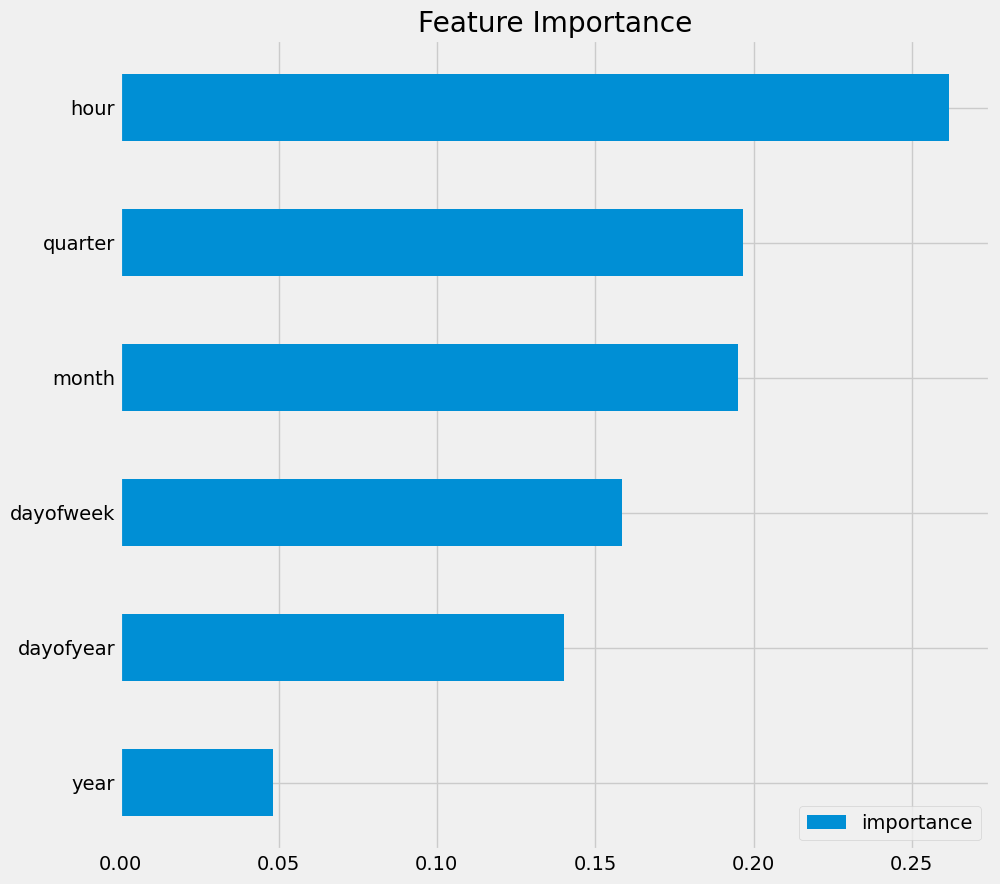

In [77]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [78]:
fi

,importance
dayofyear,0.140060
hour,0.261681
dayofweek,0.158433
quarter,0.196717
month,0.194947
year,0.048162


## Forecast 

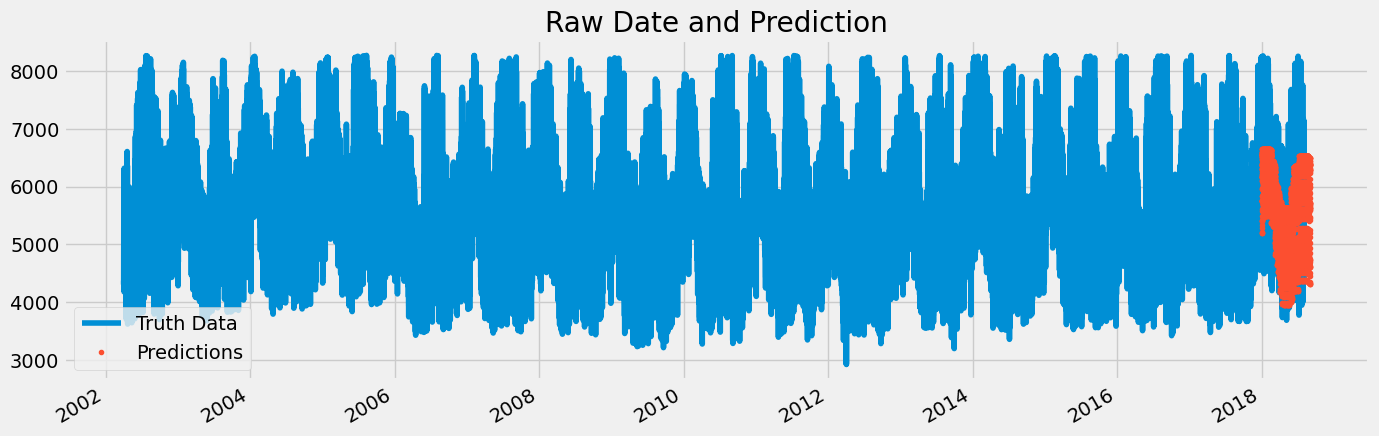

In [79]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJMW_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Date and Prediction')
plt.show()

# Next 30 Days

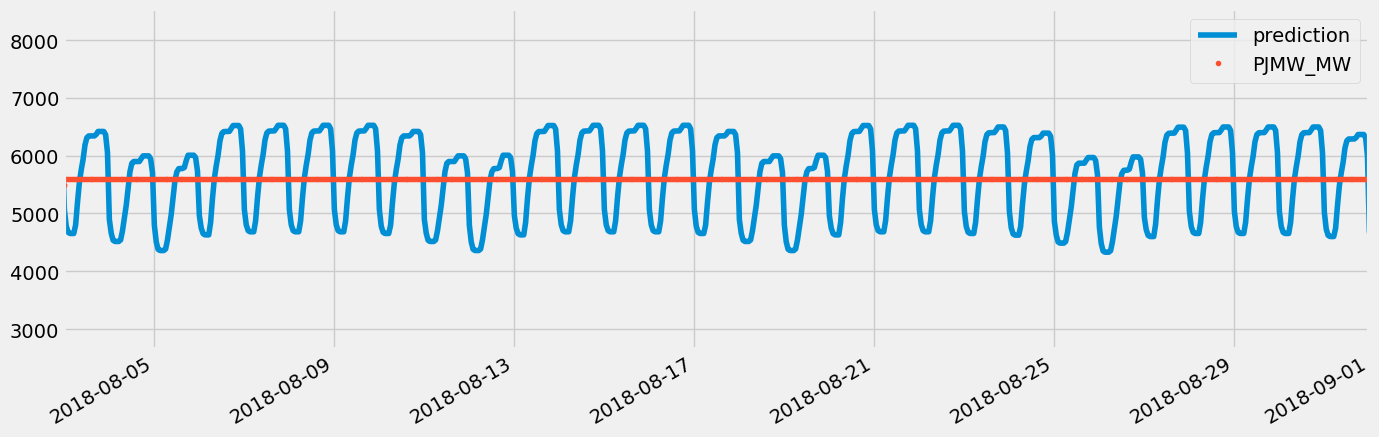

In [80]:
_, ax = plt.subplots(1)
df[['prediction','PJMW_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('2018-08-03'), upper=pd.Timestamp('2018-09-01'))

## First Week of AUG 2018

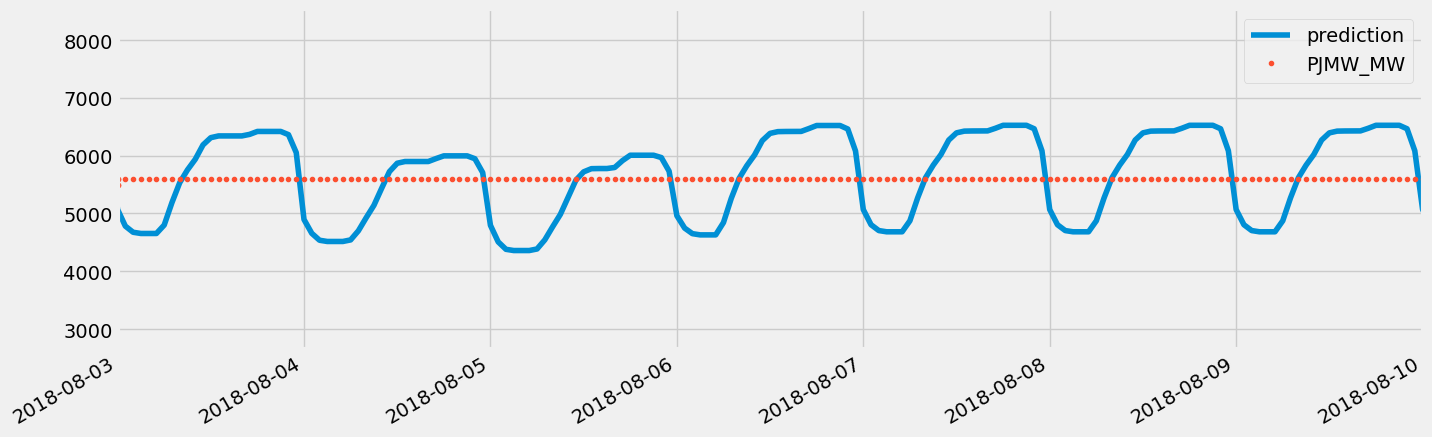

In [81]:
_, ax = plt.subplots(1)
df[['prediction','PJMW_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('2018-08-03'), upper=pd.Timestamp('2018-08-10'))

# Last Week of AUG 2018

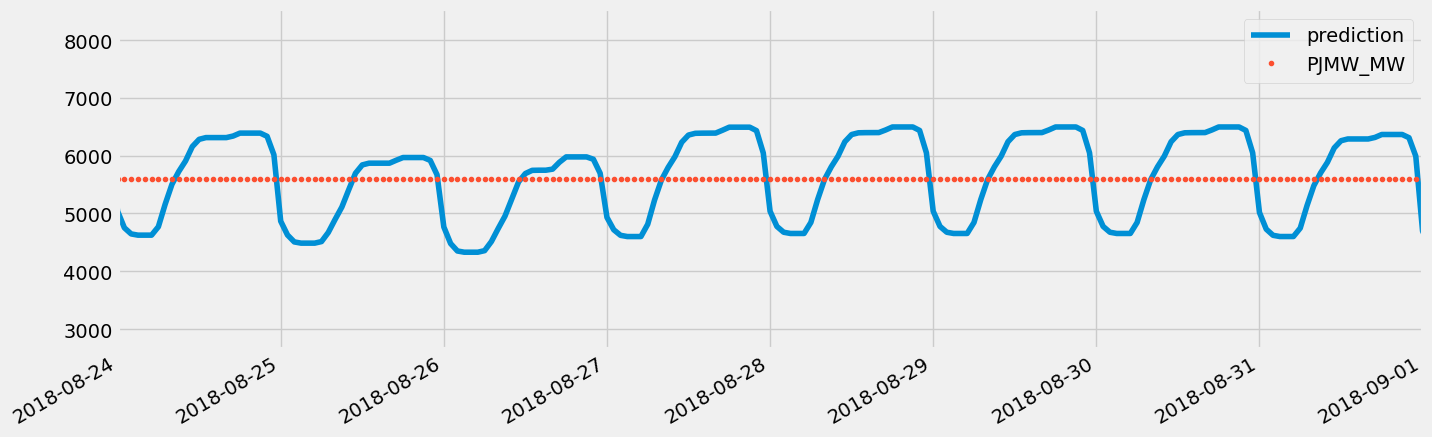

In [82]:
_, ax = plt.subplots(1)
df[['prediction','PJMW_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('2018-08-24'), upper=pd.Timestamp('2018-09-01'))

## Score RMSE / MSE / MAE

In [83]:
score = np.sqrt(mean_squared_error(test['PJMW_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 676.29


In [84]:
mean_squared_error(y_true=test['PJMW_MW'],
                   y_pred=test['prediction'])

457362.5993106678

In [85]:
mean_absolute_error(y_true=test['PJMW_MW'],
                   y_pred=test['prediction'])

530.3064237616655

## Error and Abs Error 

In [86]:
test['error'] = test['PJMW_MW'] - test['prediction']
test['abs_error'] = test['error'].apply(np.abs)

In [87]:
error_by_day = test.groupby(['year','month','dayofmonth']).mean()[['PJMW_MW','prediction','error','abs_error']]

In [88]:
error_by_day.head(10)

PJMW_MW   prediction        error    abs_error
year month dayofmonth                                                    
2018 1     1           7389.546886  5930.095215  1459.451549  1635.392933
           2           6847.447954  6134.525391   712.922380  1401.270817
           3           7274.093772  6352.609375   921.484296  1358.704181
           4           6780.114620  6352.609375   427.505144  1237.443017
           5           6027.812574  6324.597168  -296.784451  1087.085355
           6           5930.786536  6001.845215   -71.058333   708.033552
           7           7212.234401  5864.914062  1347.320135  1443.535423
           8           7383.250000  6330.730469  1052.519572  1052.519572
           9           6503.500000  6352.609375   150.890523   273.607524
           10          6509.083333  6352.609375   156.473857   360.563049

## Worst Prediction days

In [90]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJMW_MW   prediction        error    abs_error
year month dayofmonth                                                    
2018 1     1           7389.546886  5930.095215  1459.451549  1635.392933
           14          7329.541667  5873.666016  1455.875692  1455.875692
           7           7212.234401  5864.914062  1347.320135  1443.535423
           2           6847.447954  6134.525391   712.922380  1401.270817
           3           7274.093772  6352.609375   921.484296  1358.704181
           15          7183.078144  6330.933105   852.145038  1244.333925
           4           6780.114620  6352.609375   427.505144  1237.443017
           17          7140.578144  6340.265625   800.312417  1229.476035
     7     1           6321.500000  5116.998535  1204.501180  1204.501180
     2     21          5044.958333  6176.639160 -1131.681091  1131.681091

## Best Predicted days

In [91]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJMW_MW   prediction       error   abs_error
year month dayofmonth                                                  
2018 2     1           6313.083333  6338.757324  -25.674093  105.264669
     5     11          5057.458333  5073.835938  -16.377482  112.011271
     4     14          4635.250000  4702.598145  -67.348226  119.689168
           24          5100.375000  5164.038574  -63.663635  121.020121
     5     10          5214.541667  5164.038574   50.503031  137.706645
           18          5109.916667  5073.835938   36.080851  141.290120
           8           5053.750000  5164.038574 -110.288635  142.325582
     2     18          5647.291667  5734.597656  -87.306112  154.043660
     4     13          4934.375000  5075.546387 -141.171346  158.449504
     8     2           5805.041667  5822.598145  -17.556396  159.589559

## Plotting Best/Worst predicted Days

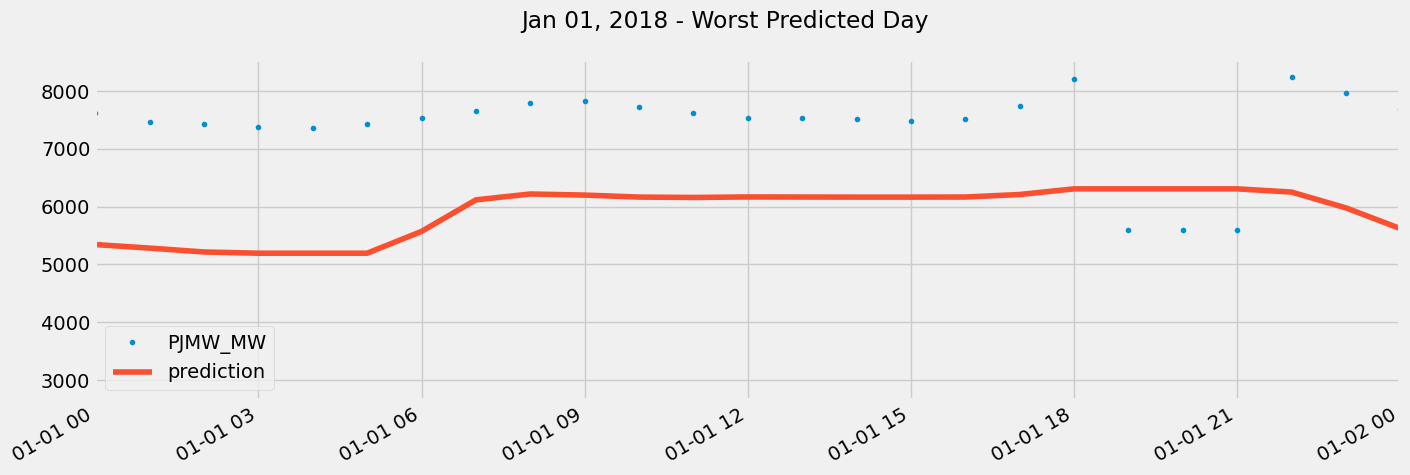

In [92]:
# Worst Predicted day
_, ax = plt.subplots(1)
df[['PJMW_MW','prediction']].plot(ax=ax, style=['.','-'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('01-01-2018'), upper=pd.Timestamp('01-02-2018'))
plot = plt.suptitle('Jan 01, 2018 - Worst Predicted Day')

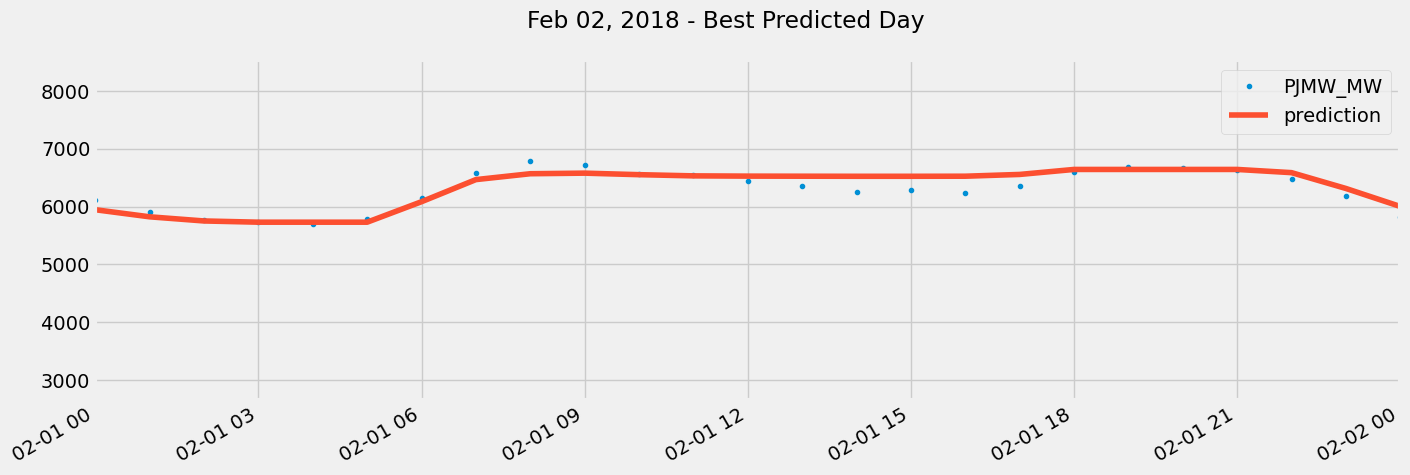

In [93]:
# Best Predicted Day
_, ax = plt.subplots(1)
df[['PJMW_MW','prediction']].plot(ax=ax, style=['.','-'],figsize=(15, 5))
ax.set_xbound(lower=pd.Timestamp('02-01-2018'), upper=pd.Timestamp('02-02-2018'))
plot = plt.suptitle('Feb 02, 2018 - Best Predicted Day')

# List of Next 30 days With their Prediction Values

In [96]:
df.tail(720)

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
2018-08-03 00:00:00,5602.375089,0,4,3,8,2018,215,3,31,5070.388672
2018-08-03 01:00:00,5602.375089,1,4,3,8,2018,215,3,31,4781.261719
2018-08-03 02:00:00,5602.375089,2,4,3,8,2018,215,3,31,4675.227051
2018-08-03 03:00:00,5602.375089,3,4,3,8,2018,215,3,31,4654.091797
2018-08-03 04:00:00,5602.375089,4,4,3,8,2018,215,3,31,4654.091797
...,...,...,...,...,...,...,...,...,...,...
2018-09-01 19:00:00,5602.375089,19,5,3,9,2018,244,1,35,5722.055664
2018-09-01 20:00:00,5602.375089,20,5,3,9,2018,244,1,35,5722.055664
2018-09-01 21:00:00,5602.375089,21,5,3,9,2018,244,1,35,5722.055664
2018-09-01 22:00:00,5602.375089,22,5,3,9,2018,244,1,35,5672.207031


## Dataset for Deployment

In [98]:
df

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
2002-04-01 01:00:00,4374.000000,1,0,2,4,2002,91,1,14,NaN
2002-04-01 02:00:00,4306.000000,2,0,2,4,2002,91,1,14,NaN
2002-04-01 03:00:00,4322.000000,3,0,2,4,2002,91,1,14,NaN
2002-04-01 04:00:00,4359.000000,4,0,2,4,2002,91,1,14,NaN
2002-04-01 05:00:00,4436.000000,5,0,2,4,2002,91,1,14,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-09-01 19:00:00,5602.375089,19,5,3,9,2018,244,1,35,5722.055664
2018-09-01 20:00:00,5602.375089,20,5,3,9,2018,244,1,35,5722.055664
2018-09-01 21:00:00,5602.375089,21,5,3,9,2018,244,1,35,5722.055664
2018-09-01 22:00:00,5602.375089,22,5,3,9,2018,244,1,35,5672.207031
